In [1463]:
import matplotlib
import scipy.optimize as opt
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

读取matlab data数据


In [1464]:
path_data = 'ex4data1'
data =  sio.loadmat(path_data)
X = data.get('X')
Y = data.get('y')
# Y = Y - 1
# Y = Y.astype(np.int)
# X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
    

编写画出100张手写图片的函数

In [1465]:
def plot_100images(X):
    random_id = np.random.choice(range(X.shape[0]), 100)
    size = int(np.sqrt(X.shape[1]))
    fig,ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(8,8))
    for i in range(10):
        for j in range(10):
            ax[i, j].matshow(X[random_id[10 * i + j]].reshape((size, size)),
                             cmap=matplotlib.cm.binary)
            plt.xticks([])
            plt.yticks([])
    plt.show()

In [1466]:
#因为调用这个函数很费时间，故在运行其他部分时将它注释
#plot_100images(X)

In [1467]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


编写将向量扁平化的函数



In [1468]:
def serialize(a, b):
  
    return np.concatenate((np.ravel(a), np.ravel(b)))


编写将扁平向量复原的函数


In [1469]:
def deserialize(input_layer_size, hidden_layer_size, num_labels, seq):

    return seq[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1),\
           seq[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)

读取matlab weight数据



In [1470]:
path_weight = 'ex4weights.mat'
weight = sio.loadmat(path_weight)
theta1 = weight.get('Theta1')
theta2 = weight.get('Theta2')
theta = serialize(theta1, theta2)

编写costFunction函数

In [1471]:
def nnCostFunction(theta, input_layer_size, hidden_layer_size, num_labels, X, Y, lamda):
    X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)    
    Y_Num = np.zeros((Y.shape[0], num_labels))
    for i in range(Y.shape[0]):
        Y_Num[i, Y[i] - 1] = 1
    theta1, theta2= deserialize(input_layer_size, hidden_layer_size, num_labels, theta)
    z2 = X @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, values=np.ones(a2.shape[0]), axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    first = -np.multiply(Y_Num, np.log(a3))
    second = np.multiply((1 - Y_Num), np.log(1 - a3))
    theta1 = np.delete(theta1, 0, axis=1)
    theta2 = np.delete(theta2, 0, axis=1)
    third = (lamda / (2 * X.shape[0])) * (np.sum(theta1 * theta1) + np.sum(theta2 * theta2))
    return (first - second).sum()/X.shape[0] +third      
        
        

In [1472]:
#用lamda是否等于零来控制是否含有正则项
J = nnCostFunction(theta=theta, input_layer_size=400, hidden_layer_size=25, num_labels=10, 
                   X=X, Y=Y, lamda=0)
print(J)

0.2876291651613189


编写gradient_sigmoid函数



In [1473]:
def gradient_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [1474]:
#验证gradient_sigmoid函数是否编写正确
Z = np.array([-1, -0.5, 0, 0.5, 1])
for z in Z:
    print(gradient_sigmoid(z))

0.19661193324148185
0.2350037122015945
0.25
0.2350037122015945
0.19661193324148185


随机初始化



In [1475]:
epsilon = 0.12
initial_theta1 = np.random.uniform(-epsilon, epsilon, theta1.shape)
initial_theta2 = np.random.uniform(-epsilon, epsilon, theta2.shape)
initial_theta = serialize(initial_theta1, initial_theta2)

编写反向传播函数

In [1476]:
def backprop(theta, input_layer_size, hidden_layer_size, num_labels, X, Y, lamda):
    X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1) 
    Y_Num = np.zeros((Y.shape[0], num_labels))
    for i in range(Y.shape[0]):
        Y_Num[i, Y[i] - 1] = 1
    theta1, theta2 = deserialize(input_layer_size, hidden_layer_size, num_labels,theta)
    z2 = X @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, values=np.ones(a2.shape[0]), axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    delta3 = a3 - Y_Num    #(5000,10)
    delta2 = np.multiply(np.dot(delta3, theta2)[:, 1:], gradient_sigmoid(z2))
    m = X.shape[0]
    
    D1 = np.dot(delta2.T, X)
    D1 = D1 / m
    theta1_modify = np.delete(theta1, 0, axis=1)
    theta1_modify = np.insert(theta1_modify, 0, values=np.zeros(theta1_modify.shape[0]), axis=1)
    regularzition_1 = lamda / m * theta1_modify
    D1 = D1 + regularzition_1
    
    D2 = np.dot(delta3.T, a2)
    D2 = D2 / m
    theta2_modify = np.delete(theta2, 0, axis=1)
    theta2_modify = np.insert(theta2_modify, 0, values=np.zeros(theta2_modify.shape[0]), axis=1)
    regularzition_2 = lamda / m * theta2_modify
    D2 = D2 + regularzition_2
    grad = np.concatenate((np.ravel(D1), np.ravel(D2)))
    print(grad.shape)
    return grad

编写梯度下降检测函数

In [1477]:
def gradient_checking(input_layer_size, hidden_layer_size, num_labels, m):
    def initialweight(output, input):
        W = range(1, (input + 1) * output + 1)
        W = np.reshape(np.sin(W), (output,input + 1)) / 10
        return W
    def computeNumericalGradient(input_layer_size, hidden_layer_size, num_labels, theta):
        e = 0.0001
        numgrid = np.zeros(len(theta))
        perturb = np.zeros(len(theta))
        for p in range(len(theta)):
            perturb[p] = e
            loss1 = nnCostFunction(theta + perturb, input_layer_size, hidden_layer_size, num_labels, X, Y, 1)
            loss2 = nnCostFunction(theta - perturb, input_layer_size, hidden_layer_size, num_labels, X, Y, 1)
            numgrid[p] = (loss1 - loss2) / (2*e)
            perturb[p] = 0
        return numgrid
    theta1 = initialweight(hidden_layer_size, input_layer_size)
    theta2 = initialweight(num_labels, hidden_layer_size)
    theta = serialize(theta1, theta2)
    X = initialweight(m, input_layer_size - 1)
    Y = np.array([2,3,1,2,3])
    grad = backprop(theta, input_layer_size, hidden_layer_size, num_labels, X, Y, 1)
    numgrad = computeNumericalGradient(input_layer_size, hidden_layer_size, num_labels,theta)
    diff = np.linalg.norm(numgrad-grad) / np.linalg.norm(numgrad+grad);
    print(diff)
    print(numgrad)

In [1478]:
#验证完求代价函数的导数是正确的的之后就可以关掉了，因为计算起来很慢
#gradient_checking(input_layer_size=3, hidden_layer_size=5, num_labels=3, m=5)

开始训练网络


In [1479]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lamda = 1
res = opt.minimize(fun= nnCostFunction, x0= initial_theta, args= (input_layer_size, hidden_layer_size, num_labels, X, Y, lamda), 
                   method='TNC', jac=backprop, options={'maxiter': 400})
print(res)


(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(10285,)
(

编写预测函数


In [1480]:
def predict(theta, input_layer_size, hidden_layer_size, num_labels, X, Y):
    X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1) 
    Y_Num = np.zeros((Y.shape[0], num_labels))
    for i in range(Y.shape[0]):
        Y_Num[i, Y[i] - 1] = 1
    theta1, theta2 = deserialize(input_layer_size, hidden_layer_size, num_labels,theta)
    z2 = X @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, values=np.ones(a2.shape[0]), axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    y_pred = np.argmax(a3, axis=1) + 1
    # print(int(y_pred[10]))
    count = 0;
    for i in range(Y.shape[0]):
        if int(y_pred[i]) == int(Y[i]):
            count = count + 1
    print( count / Y.shape[0])

In [1481]:
predict(theta= res.x, input_layer_size= 400 , hidden_layer_size= 25, num_labels= 10, X= X, Y= Y)



0.9954


编写隐藏层可视化函数

In [1482]:
def plot_hiden(X):
    X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1) 
    theta1, theta2 = deserialize(input_layer_size, hidden_layer_size, num_labels,theta)
    z2 = X @ theta1.T
    a2 = sigmoid(z2)
    hiddden_X = a2
    random_id = np.random.choice(range(hiddden_X.shape[0]), 25)
    fig, ax = plt.subplots(nrows= 5, ncols= 5, sharex= True, sharey= True, figsize= (8,8))
    size = int(np.sqrt(hiddden_X.shape[1]))
    for i in range(5):
        for j in range(5):
            ax[i, j].matshow(hiddden_X[random_id[5 * i + j]].reshape((size, size)), cmap= matplotlib.cm.binary)
            plt.xticks([])
            plt.yticks([])
    plt.show()

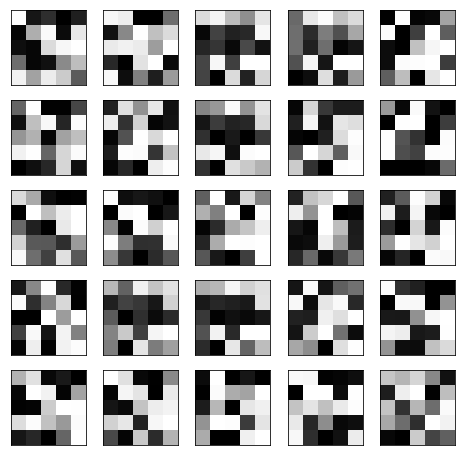

In [1483]:
plot_hiden(X)

